In [ ]:
'''
1. 필요한거 설치
2. MP Holistic을 사용해 keypoints를 인식 (이미지 1개만)
3. keypoints 추출 및 저장 (pose, lh, rh, lh_a, rh_a) (이미지 1개만)
4. 폴더 생성
5. 데이터셋 생성
6. 라벨 생성 (지도 학습)
7. 모델 생성 및 LSTM 학습, tensorboard
8. 테스트 데이터로 예측
9. 가중치 저장
10. 혼동 행렬
11. 실제로 테스트
출처: https://www.youtube.com/watch?v=doDUihpj6ro&t=7803s
'''

# 1. Import and Install Dependencies

In [4]:
# !pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib
# %pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib
%pip install tensorflow==2.8.0 tensorflow-gpu==2.8.0 opencv-python mediapipe sklearn matplotlib

  Using cached tensorflow-2.8.0-cp310-cp310-win_amd64.whl (438.0 MB)
     -------------------------------------- 438.0/438.0 MB 5.4 MB/s eta 0:00:00
     ---------------------------------------- 1.4/1.4 MB 17.3 MB/s eta 0:00:00
     -------------------------------------- 462.5/462.5 kB 7.3 MB/s eta 0:00:00
     ---------------------------------------- 5.8/5.8 MB 12.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.10.0
    Uninstalling keras-2.10.0:
      Successfully uninstalled keras-2.10.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.0
    Uninstalling tensorboard-2.10.0:
      Successfully uninstalled tensorboard-2.10.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.10.0
    Uninstalling tensorflow-2.10.0:
      Successfully uninstalled tensorflow-2.10.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# 2. Keypoints using MP Holistic

In [4]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

# mp_holistic (holistic=전체론의)
# detect되는 key points 전체를 받을 모델을 정의
# mp_drawing
# 모델에 저장된 key points를 화면에 그려줄 util

In [5]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

# image = frame, model = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)로 생성된 모델
#     image를 RGB로 변환
#     model로 keypoints 추출 후 results에 저장
#     image를 BGR로 변환
#     image, results 리턴


In [6]:
def draw_landmarks(image, results):
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

# image = frame, results = detected key points
#     mp_drawing에 있는 draw_landmarks 함수를 사용해라
#     image에 그려라
#     results에 있는 pose_landmarks 속성을 (results에 얼굴, 왼손, 오른손, 자세 key points 집합이 각각 들어있음)
#     mp_holistic.POSE_CONNECTIONS 방식에 따라서 (1번 점을 몇번 점에 연결할지 집합에 따라 다름)

In [7]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    # mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION,
    #                          mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
    #                          mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
    #                          ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

# image = frame, results = detected key points
#     똑같이 그리되 점과 연결선의 색깔과 크기를 바꿀 수 있음

In [8]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    
# 0번 웹캠을 사용
# confidence가 0.5인 holistic model을 사용
#     웹캠이 열려있다면
#         영상을 읽는다 (ret=성공/실패, frame=프레임)

#         frame마다 holistic 모델을 사용하여 key points를 detect 후 (image = frame), (results = detected keypoints) 반환

#         image(frame)에 detected keypoints를 사용자 정의로 그리기

#         화면에 출력

#         10ms마다 화면 갱신, 그리고 'q' 입력시 종료
#     웹캠 자원 반환
#     모든 윈도우창 종료
    

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [9]:
print(results.left_hand_landmarks)
len(results.left_hand_landmarks.landmark)

# detected keypoints 확인
# detected keypoints len 확인

landmark {
  x: 0.9399141669273376
  y: 0.8587459325790405
  z: 1.9795258765498147e-07
}
landmark {
  x: 0.8470437526702881
  y: 0.864753246307373
  z: -0.015284833498299122
}
landmark {
  x: 0.7490750551223755
  y: 0.8197708129882812
  z: -0.018664710223674774
}
landmark {
  x: 0.6812301278114319
  y: 0.7846124172210693
  z: -0.02390005812048912
}
landmark {
  x: 0.6276617646217346
  y: 0.763360857963562
  z: -0.028343278914690018
}
landmark {
  x: 0.7563682794570923
  y: 0.6490120887756348
  z: 0.014575392939150333
}
landmark {
  x: 0.692702054977417
  y: 0.5736557245254517
  z: 0.0016727952752262354
}
landmark {
  x: 0.6520962715148926
  y: 0.5365479588508606
  z: -0.01590898260474205
}
landmark {
  x: 0.6126084923744202
  y: 0.5014063119888306
  z: -0.03094586171209812
}
landmark {
  x: 0.7900019288063049
  y: 0.6084432601928711
  z: 0.004675236530601978
}
landmark {
  x: 0.7271026968955994
  y: 0.5157438516616821
  z: -0.004288619849830866
}
landmark {
  x: 0.6850504875183105
  y:

21

In [10]:
results

# results는 mediapipe.python.solution_base.SolutionOutputs 객체로 반환됨
# (results 안에 results.pose_landmarks 속성들이 있는 거임)

mediapipe.python.solution_base.SolutionOutputs

In [11]:
draw_landmarks(frame, results)

# 기본 색상으로 frame에 detected keypoints 그리기

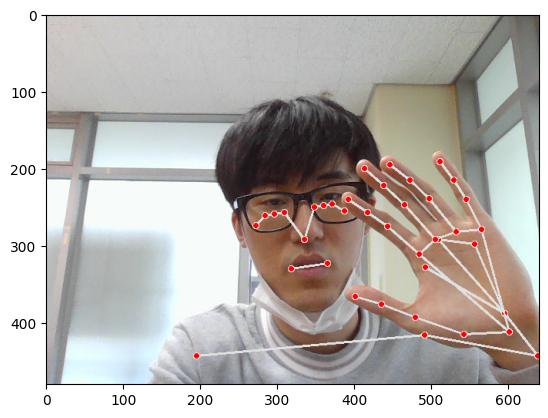

In [12]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# 그려진 frame을 RGB로 변환해서 출력

# 3. Extract Keypoint Values

In [13]:
len(results.left_hand_landmarks.landmark)

# results 안에 있는 left_hand landmark 개수 확인

21

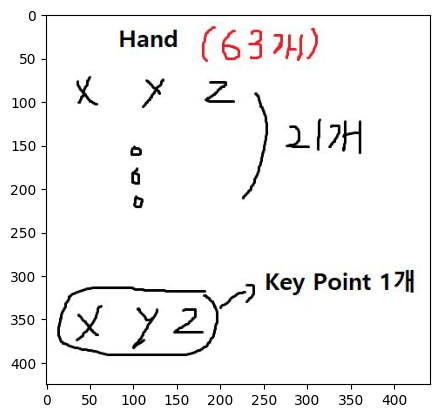

In [14]:
import matplotlib.image as img

hand_shape = img.imread('./img/hand_shape.jpg')
plt.imshow(hand_shape)
plt.show()


In [15]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

# pose는 특이하게 visibility 속성이 추가로 하나 더 있음
# x = x좌표
# y = y좌표
# z = 카메라와의 거리
# visibility = 해당 포즈_랜드마크에 정의된 것과 동일합니다. (pose 여서 같은 포즈인지 봐주는 그런 속성인듯?)

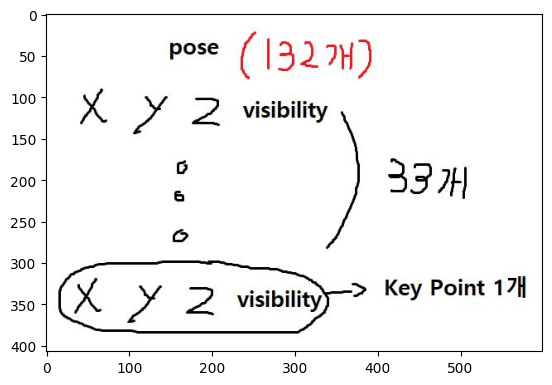

In [16]:
pose_shape = img.imread('./img/pose_shape.jpg')
plt.imshow(pose_shape)
plt.show()

In [20]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(132)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

# 함수 만들기 전에 확인용
# detect 된 landmarks가 있다면, landmarks를 flatten(1차원 배열)으로 만든다
# detect 된 landmarks가 없다면, np.zeros로 각 속성 shape에 맞는 zeros 배열 생성
# pose = 33행 4열 = 132
# face = 468행 3열 = 1404
# lh = 21행 3열 = 63
# rh = 21행 3열 = 63

In [17]:
def cal_angle(res):
    joint = np.zeros((21, 3)) # joint == 랜드마크에서 빨간 점, joint는 21개가 있고 x,y,z 좌표니까 21,3
    if res:
        for j, lm in enumerate(res.landmark):
            joint[j] = [lm.x, lm.y, lm.z] # 각 joint마다 x,y,z 좌표 저장
        # Compute angles between joints joint마다 각도 계산
        # **공식문서 들어가보면 각 joint 번호의 인덱스가 나옴**
        # print('joint:',joint)
        v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19],:] # Parent joint
        v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],:] # Child joint
        v = v2 - v1 # [20,3]관절벡터 
        # Normalize v
        v = v / np.linalg.norm(v, axis=1)[:, np.newaxis] # 벡터 정규화(크기 1 벡터) = v / 벡터의 크기
        # print('v:',v)

        # Get angle using arcos of dot product **내적 후 arcos으로 각도를 구해줌**
        angle = np.arccos(np.einsum('nt,nt->n',
            v[[0,1,2,4,5,6,7,8,9,10,12,13,14,16,17],:], 
            v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

        angle = np.degrees(angle) # Convert radian to degree
        # print('angle:',angle)

        # Inference gesture 학습시킨 제스처 모델에 참조를 한다. 
        # data = np.array([angle], dtype=np.float32)
        # print('data:',data)
        return angle
    else:
        return np.zeros((15, 1)).flatten()

# 손가락 각도 계산한 매개변수를 모델 학습에 사용하기 위해 추가한 함수
# res = results.left_hand_landmarks 또는 results.right_hand_landmarks
# 각각 각도를 계산한 후 배열로 반환
# angle.shape = (15,) = 1행 15열 

In [16]:
aaa = cal_angle(results.left_hand_landmarks)
bbb = results.left_hand_landmarks
# print('results:', bbb.landmark)
print(aaa.shape)
print(np.array([1,2,3,4,5]).shape)

# angle shape 확인용

(15,)
(5,)


In [18]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    # face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    lh_a = cal_angle(results.left_hand_landmarks)
    rh_a = cal_angle(results.right_hand_landmarks)
    # return np.concatenate([pose, face, lh, rh])
    # return np.concatenate([pose, face, lh, rh, lh_a, rh_a])
    return np.concatenate([pose, lh, rh, lh_a, rh_a])

# 각각 1차원으로 반환된 배열들을 합쳐서 반환 (288,)
# pose + lh + rh + lh_a + rh_a = 132 + 63 + 63 + 15 + 15 = 288
# 후에 이 배열을 LSTM 인공신경망 학습에 사용할 예정
# extract_keypoints(results)로 1프레임의 keypoints를 1차원 배열로 추출한거고 이걸 30번 반복해서 동작으로 학습시킴
# 1 frame에 1 배열 (288개)

In [18]:
aaa = extract_keypoints(results)
print(aaa.shape)

# extract_keypoints(results) shape 확인용

(288,)


In [21]:
print('pose',pose.shape, type(pose))
print('lh',lh.shape,type(lh))
print('rh',rh.shape,type(rh))
lh_a = cal_angle(results.left_hand_landmarks)
rh_a = cal_angle(results.right_hand_landmarks)
print('lh_a',lh_a.shape,type(lh_a))
print('lh_a',rh_a.shape,type(rh_a))

# 모든 배열 확인용

pose (132,) <class 'numpy.ndarray'>
lh (63,) <class 'numpy.ndarray'>
rh (63,) <class 'numpy.ndarray'>
lh_a (15,) <class 'numpy.ndarray'>
lh_a (15,) <class 'numpy.ndarray'>


In [ ]:
# joint = np.zeros((21, 3)) # joint == 랜드마크에서 빨간 점, joint는 21개가 있고 x,y,z 좌표니까 21,3
# for j, lm in enumerate(res.landmark):
#     joint[j] = [lm.x, lm.y, lm.z] # 각 joint마다 x,y,z 좌표 저장

# # Compute angles between joints joint마다 각도 계산 
# # **공식문서 들어가보면 각 joint 번호의 인덱스가 나옴**
# v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19],:] # Parent joint
# v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],:] # Child joint
# v = v2 - v1 # [20,3]관절벡터 
# # Normalize v
# v = v / np.linalg.norm(v, axis=1)[:, np.newaxis] # 벡터 정규화(크기 1 벡터) = v / 벡터의 크기

# # Get angle using arcos of dot product **내적 후 arcos으로 각도를 구해줌** 
# angle = np.arccos(np.einsum('nt,nt->n',
#     v[[0,1,2,4,5,6,7,8,9,10,12,13,14,16,17],:], 
#     v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

# angle = np.degrees(angle) # Convert radian to degree

# # Inference gesture 학습시킨 제스처 모델에 참조를 한다. 
# data = np.array([angle], dtype=np.float32)
# ret, results, neighbours, dist = knn.findNearest(data, 3) # k가 3일 때 값을 구한다! 
# idx = int(results[0][0]) # 인덱스를 저장!

# 혜원님한테 받은 손가락 각도 계산하는 코드 원본

In [19]:
result_test = extract_keypoints(results)

In [20]:
result_test.shape

(288,)

In [24]:
33*4+21*3+21*3+15+15

288

In [51]:
np.save('0', result_test)

# np.save = 넘파이 배열을 저장하는 함수
# np.save('파일이름', 저장할 넘파이 배열)

In [52]:
np.load('0.npy')

# np.load = 넘파이 배열을 로드하는 함수
# np.load('로드할 파일 이름')

array([ 0.54491466,  0.57633948, -0.72666007, ...,  0.        ,
        0.        ,  0.        ])

# 4. Setup Folders for Collection

In [21]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'iloveyou'])

# Thirty videos worth of data #aaa
no_sequences = 30
# no_sequences = 5

# Videos are going to be 30 frames in length
sequence_length = 30

# 작업 위치를 MP_Data 폴더로 한다
# 분류하려는 동작 3개 (hello, thanks, iloveyou)
# 학습에 사용할 데이터(비디오) 30개
# 비디오 1개의 프레임은 30

In [209]:
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 3번 반복 (hello, thanks, iloveyou)
# 30번 반복 (원하는 동영상 개수 30개)
# 없다면 MP_Data/hello/0 폴더를 만들고, 있다면 pass
# <결과>
# MP_Data
#     - hello
#         - 0
#         - 1
#         - ...
#         - 29
#     - thanks
#         - 0
#         - 1
#         - ...
#         - 29
#     -iloveyou
#         - 0
#         - 1
#         - ...
#         - 29
# 아직은 빈 폴더

# 5. Collect Keypoint Values for Training and Testing

In [210]:
cap = cv2.VideoCapture(0)
# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints #aaa
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

#     웹캡 0번 카메라 사용
#     신뢰도 0.5 holistic model 사용
#     3번 반복 (hello, thanks, iloveyou)
#         30번 반복 (동영상 30개)
#             30번 반복 (프레임 30개)
#                 성공, frame 반환
#                 1 frame, 1 frame의 keypoints 반환 (frame마다 keypoints detect)
#                 detected landmarks 그리기

#                 frame 시작한다면
#                     STARTING COLLECTION를 화면 중앙에 출력
#                     화면 위쪽에 Collecting frames for {action} Video Number {sequence} 출력
#                     frame 출력
#                     2초 가다림
#                 frame 중이라면
#                     화면 위쪽에 Collecting frames for {action} Video Number {sequence} 출력
#                     frame 출력

#                 현재 frame의 keypoints 추출
#                 MP_Data/hello/0/0번 프레임
#                 넘파이 배열 저장

#                 10ms마다 프레임 출력, 'q' 입력시 종료
# 웹캠 자원 반환
# 윈도우 창 전부 종료

In [158]:
cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [22]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [23]:
label_map = {label:num for num, label in enumerate(actions)}

# label map 생성

In [24]:
label_map

# label map 확인

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [25]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

# sequences = 동영상 90를 담을 배열, labels = 해당 동영상에 맞는 label
# 3번 반복 (hello, thanks, iloveyou)
#     30번 반복 (동영상 30개)
#         window = 동영상 1개 (30프레임을 1개로)
#         30번 반복 (30프레임)
#             MP_Data/hello/0/0.npy 로드 (npy는 numpy 배열)
#             30번 반복하면서 windwo에 프레임을 append
#         sequences에 프레임 30번을 반복해서 만든 동영상 1개를 append
#         labels에 해당 동영상에 맞는 라벨을 append

In [26]:
np.array(sequences).shape

# 동영상 30+30+30개, 30프레임, 288개의 values(keypoints,angles)를 가지는

(90, 30, 288)

In [27]:
np.array(labels).shape

# 30+30+30개의 라벨

(90,)

In [28]:
X = np.array(sequences)

In [29]:
X.shape

(90, 30, 288)

In [30]:
y = to_categorical(labels).astype(int)

# to_categorical() = 원-핫 인코딩 함수

In [31]:
labels

# 원-핫 인코딩 전

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [32]:
y

# 원-핫 인코딩 후

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

# X, y 데이터를 나눠라 (테스트 데이터는 5%로)

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((85, 30, 288), (5, 30, 288), (85, 3), (5, 3))

# 7. Build and Train LSTM Neural Network

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [36]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

# log_dir의 작업 경로를 Logs로 지정
# tensorboard log_dir 경로가 log_dir(Logs)인 콜백 함수 생성

In [37]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 288)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

# Sequential API
# 레이어의 흐름이 순차적인 경우 사용 (layer-by-layer)
# 텐서가 이전 레이어에서 다음 레이어로 바로 이어질 때에 사용 가능

# Functional API
# Sequential API보다 유연한 API로 다음의 기능을 사용할 수 있음
# 여러 개의 input을 받거나 여러 개의 output을 내야 하는 경우
# Layer을 공유하는 경우 (샴 네트워크 등....)
# Residual Network 구현

# LSTM()
# LSTM (Long Short Term Memory)는 기존의 RNN이 출력과 먼 위치에 있는 정보를 기억할 수 없다는 단점을 보완하여 
# 장/단기 기억을 가능하게 설계한 신경망의 구조를 말합니다. 주로 시계열 처리나, 자연어 처리에 사용됩니다.
# units = dimensionality of the output space. (출력 뉴런의 수를 설정합니다.)
# return_sequences = Whether to return the last output in the output sequence, or the full sequence.
# activation = Activation function to use.
# input_shape = LSTM의 첫번째 layer에는 input_shape를 넣어줘야한다.

# Dense()
# Dense Layer의 각 뉴런이 이전 계층의 모든 뉴런으로부터 입력을 받게 됩니다. (거의 맨 마지막 레이어)
# Dense Layer는 간단히 말해서 추출된 정보들을 하나의 레이어로 모으고, 우리가 원하는 차원으로 축소시켜서 표현하기 위한 레이어입니다. 
# 보통 맨 마지막 레이어로 분류기의 경우 softmax를 사용하는데, softmax의 인풋으로 들어가는 inputput layer로 자주 사용됩니다.
# units = dimensionality of the output space. (출력 뉴런의 수를 설정합니다.)
# activation = Activation function to use.

# 1. less data required
# 2. faster to train
# 3. faster detections (in realtime)

# https://wikidocs.net/22886
# https://keras.io/api/layers/recurrent_layers/lstm/
# https://keras.io/api/layers/core_layers/dense/

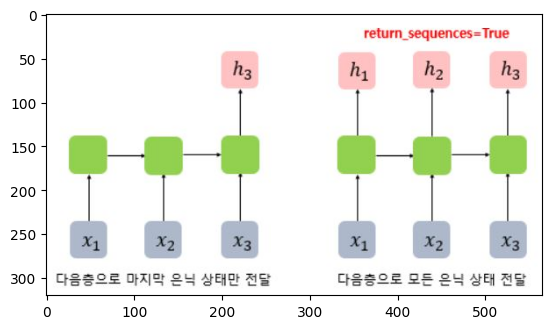

In [38]:
re_se_img = img.imread('./img/return_sequences.jpg')
plt.imshow(re_se_img)
plt.show()

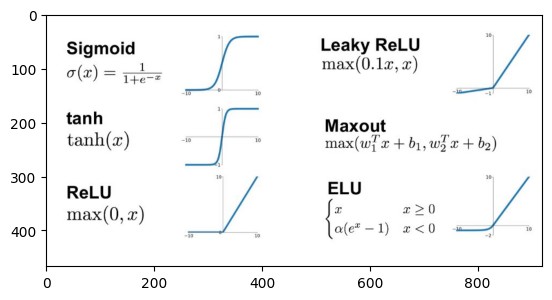

In [39]:
activation_img = img.imread('./img/활성화 함수.jpg')
plt.imshow(activation_img)
plt.show()

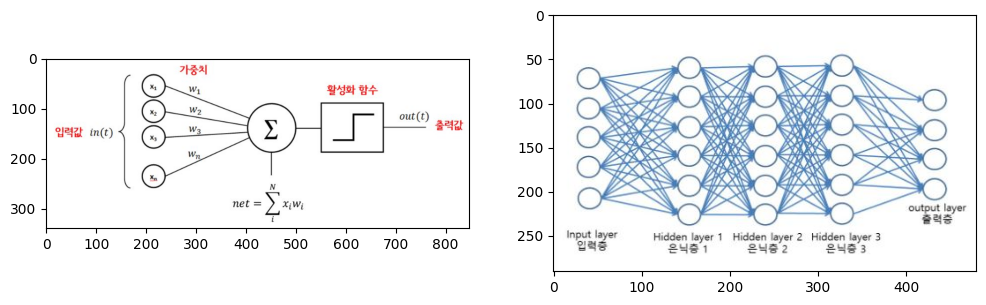

In [40]:
plt.figure(figsize=(12,8))

perceptron_img = img.imread('./img/퍼셉트론.jpg')
plt.subplot(121)
plt.imshow(perceptron_img)

mul_perceptron_img = img.imread('./img/다층 퍼셉트론.jpg')
plt.subplot(122)
plt.imshow(mul_perceptron_img)

plt.show()

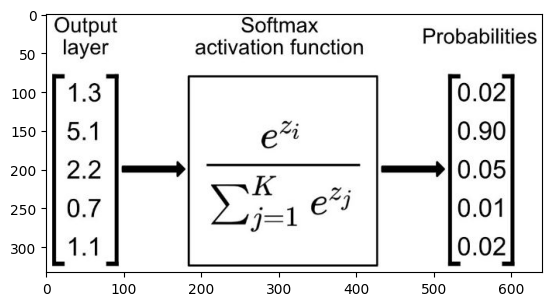

In [41]:
softmax_img = img.imread('./img/softmax.jpg')
plt.imshow(softmax_img)
plt.show()

In [42]:
X.shape

# input_shape 확인

(90, 30, 288)

In [43]:
actions.shape[0]

# 최종 출력 units 갯수 확인

3

In [44]:
res = [.7, 0.2, 0.1]

# softmax 출력 결과 예시

In [45]:
actions[np.argmax(res)]

# softmax 출력 결과에 따른 행동 분류

'hello'

In [46]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# compile()
# optimizer = 최적화를 어떤 방식으로 할건지
# loss = 손실함수 (Binary, Multiclass)
# Binary Classification
# Binary classification loss function comes into play when solving a problem involving just two classes.

# Multiclass classification
# Problems involving the prediction of more than one class use different loss functions.

# Categorical Crossentropy
# The CategoricalCrossentropy also computes the cross-entropy loss between the true classes and predicted classes. 
# The labels are given in an one_hot format. 

# Metrics = A metric is a function that is used to judge the performance of your model.
# CategoricalAccuracy class
# Calculates how often predictions match one-hot labels.

# https://neptune.ai/blog/keras-loss-functions
# https://keras.io/api/metrics/
# https://keras.io/api/metrics/accuracy_metrics/#categoricalaccuracy-class

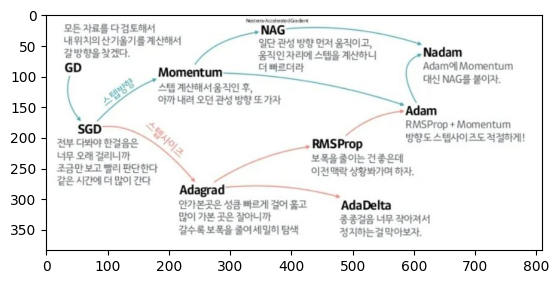

In [47]:
optimizer_img = img.imread('./img/optimizer.jpg')
plt.imshow(optimizer_img)
plt.show()

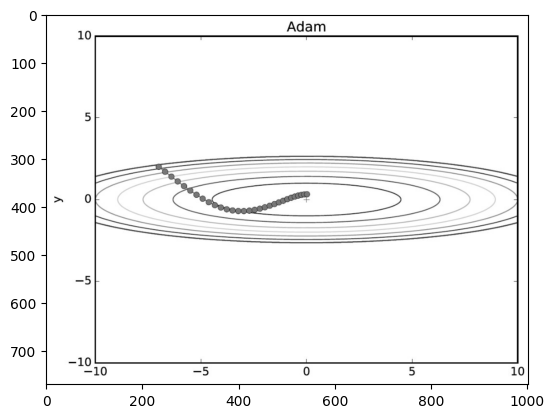

In [48]:
adam_img = img.imread('./img/adam.jpg')
plt.imshow(adam_img)
plt.show()

In [49]:
model.fit(X_train, y_train, epochs=200, callbacks=[tb_callback])

# fit(): Trains the model for a fixed number of epochs
# epochs = 훈련 데이터셋에 포함된 모든 데이터들이 한 번씩 모델을 통과한 횟수로, 모든 학습 데이터셋을 학습하는 횟수를 의미한다.
#          epoch가 10회라면, 학습 데이터 셋 A를 10회 모델에 학습시켰다는 것이다.

# log_dir = os.path.join('Logs')
# tb_callback = TensorBoard(log_dir=log_dir) (폴더 가면 log 파일이 생성되어 있음)

# activate han
# cd C:\Users\user\Desktop\허미현 강사님\2022.10.04\ActionDetectionforSignLanguage-main\Logs\train
# tensorboard --logdir=.

Epoch 1/200
3/3 [==============================] - 3s 47ms/step - loss: 55.8160 - categorical_accuracy: 0.3647
Epoch 2/200
3/3 [==============================] - 0s 44ms/step - loss: 24.1085 - categorical_accuracy: 0.3294
Epoch 3/200
3/3 [==============================] - 0s 45ms/step - loss: 22.5183 - categorical_accuracy: 0.4235
Epoch 4/200
3/3 [==============================] - 0s 47ms/step - loss: 18.2088 - categorical_accuracy: 0.3765
Epoch 5/200
3/3 [==============================] - 0s 47ms/step - loss: 15.6191 - categorical_accuracy: 0.4941
Epoch 6/200
3/3 [==============================] - 0s 48ms/step - loss: 8.0523 - categorical_accuracy: 0.6235
Epoch 7/200
3/3 [==============================] - 0s 51ms/step - loss: 10.9824 - categorical_accuracy: 0.4824
Epoch 8/200
3/3 [==============================] - 0s 47ms/step - loss: 9.4743 - categorical_accuracy: 0.5059
Epoch 9/200
3/3 [==============================] - 0s 52ms/step - loss: 9.8695 - categorical_accuracy: 0.5294
Epoc

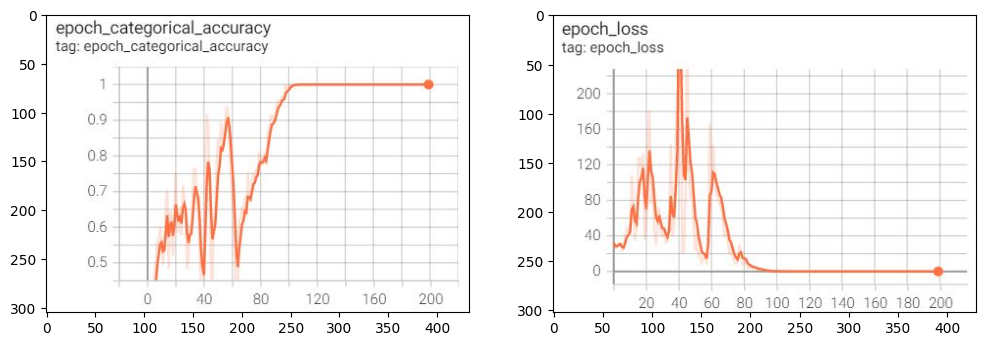

In [50]:
plt.figure(figsize=(12,8))

perceptron_img = img.imread('./img/tensorboard1.jpg')
plt.subplot(121)
plt.imshow(perceptron_img)

mul_perceptron_img = img.imread('./img/tensorboard2.jpg')
plt.subplot(122)
plt.imshow(mul_perceptron_img)

plt.show()

In [51]:
model.summary()

# 모델 요약

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            90368     
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 244,931
Trainable params: 244,931
Non-trai

# 8. Make Predictions

In [52]:
res = model.predict(X_test)

# 테스트 데이터 예측

In [53]:
np.sum(res[0])

# softmax가 반환하는 결과값의 합계는 1

1.0

In [54]:
res[0]

# hello thanks iloveyou 추정확률

array([0., 0., 1.], dtype=float32)

In [55]:
np.argmax(res[0])

# 그중 max값의 인덱스를 반환 후 action으로 action으로 출력

2

In [56]:
actions[np.argmax(res[0])], actions[np.argmax(res[1])], actions[np.argmax(res[2])], actions[np.argmax(res[3])], actions[np.argmax(res[4])]

# 모델의 예측 결과

('iloveyou', 'iloveyou', 'hello', 'thanks', 'hello')

In [57]:
actions[np.argmax(y_test[0])], actions[np.argmax(y_test[1])], actions[np.argmax(y_test[2])], actions[np.argmax(y_test[3])], actions[np.argmax(y_test[4])]

# 실제 테스트 데이터의 정답

('iloveyou', 'thanks', 'hello', 'thanks', 'hello')

# 9. Save Weights

In [250]:
model.save('action.h5')

# 학습이 완료된 모델 저장

In [81]:
# del model

# 모델 삭제

In [187]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 288)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.load_weights('action.h5')

# 모델 기본값 설정 후
# 저장해둔 가중치만 로드

# 10. Evaluation using Confusion Matrix and Accuracy

In [92]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [97]:
yhat = model.predict(X_test)

In [98]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [99]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[3, 0],
        [0, 2]],

       [[3, 0],
        [0, 2]],

       [[4, 0],
        [0, 1]]], dtype=int64)

In [96]:
accuracy_score(ytrue, yhat)

1.0

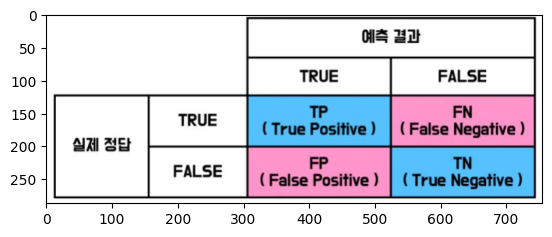

In [100]:
conf_mat_img = img.imread('./img/confusion matrix.jpg')
plt.imshow(conf_mat_img)
plt.show()

# 11. Test in Real Time

In [58]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

# 프로그레스 바 색상 설정
# res = 모델이 예측한 비율 (0.7 0.2 0.1)
# actions = hello, thanks, iloveyou
# input_frame = 프레임
# colors = 선언해 둔 색상 배열
#     받은 프레임을 카피
#     3번 반복 (hello, thanks, iloveyou)
#         enumerate를 사용해서 각 단어마다 40px 씩 떨어져서 사각형 출력
#         사각형 위치에 텍스트 출력

#     프레임 반환

In [59]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

# 테스트용. 실시간 detection 한번 했다가 끄고 나서 해야됨

TypeError: only size-1 arrays can be converted to Python scalars

<Figure size 1800x1800 with 0 Axes>

In [104]:
sequence.reverse()

# 테스트용. 실시간 detection 한번 했다가 끄고 나서 해야됨

AttributeError: 'int' object has no attribute 'reverse'

In [23]:
len(sequence)

# 테스트용. 실시간 detection 한번 했다가 끄고 나서 해야됨

1

In [51]:
sequence.append('def')

In [34]:
sequence.reverse()

In [ ]:
sequence[-30:]

In [86]:
import statistics

In [87]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.8

# sequence = 실시간 영상에서 30프레임씩 잘라넣을 배열
# sentence = 화면 위쪽에 단어를 5개까지만 출력할 배열
# predictions = 예측 성능 향상에 사용할 배열
# threshold = threshold 이상일 경우 해당 행동이 맞다고 판단할 수치

# 0번 웹캠 사용
cap = cv2.VideoCapture(0)

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # 웹캠이 열려있다면
    while cap.isOpened():

        # Read cap (ret=success or fail, frame=프레임)
        ret, frame = cap.read()

        # Make detections
        # 해당 프레임에서 keypoints detect (image=detect에 사용한 프레임, results=detect된 keypoints 객체)
        image, results = mediapipe_detection(frame, holistic)
        # print(results)
        
        # Draw landmarks
        # 사용자 설정 landmarks 그리기
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        # extract_keypoints => return np.concatenate([pose, lh, rh, lh_a, rh_a])
        # 인식된 keypoints 전부 1차원 배열로 합쳐서 반환
        keypoints = extract_keypoints(results)
        # sequence 배열에 추출한 keypoints 배열 append
        sequence.append(keypoints)
        # 가장 최근 30프레임만 사용
        sequence = sequence[-30:]
        
        # sequence가 30프레임이 다 찼다면
        if len(sequence) == 30:
            # 3차원으로 바꿔서 model로 predict (밑에 추가설명 있음)
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            # 예측한 행동 출력
            # print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            # 최근 10프레임의 예측 중 최빈값이 res의 값과 같다면
            if statistics.mode(predictions[-10:])==np.argmax(res):
                # 예측한 결과중 최댓값이 threshold를 넘을경우
                if res[np.argmax(res)] > threshold:
                    # 이미 전에 출력한 단어가 있다면
                    if len(sentence) > 0:
                        # 현재 행동이 이전 행동과 같지 않을 경우에만, 화면상에 출력 (중복 방지)
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    # 처음 출력이라면, 화면상에 출력
                    else:
                        sentence.append(actions[np.argmax(res)])

            # 단어가 5개가 넘어갔다면, 최근 5단어만 화면에 출력
            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            # 프로그레스바 출력
            image = prob_viz(res, actions, image, colors)
            
        # 화면 위쪽에 최근 탐지한 행동 5개를 화면에 출력
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        # 최종 결과물 화면에 출력
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [247]:
res[np.argmax(res)] > threshold

# 신뢰도가 threshold(사용자 지정) 이상일 때 해당 행동이라고 판단

True

In [102]:
X_test[0].shape

# model.predict는 3차원 배열을 넣어줘야함 그런데 동영상 1개를 넣으려면 2차원 배열이 됨

(30, 288)

In [106]:
np.expand_dims(X_test[0], axis=0).shape

# expand_dims 함수를 이용해서 3차원 배열로 바꿔줌

(1, 30, 288)

In [107]:
model.predict(np.expand_dims(X_test[0], axis=0))

# predict가 정상적으로 작동

array([[1.0000000e+00, 1.8557051e-27, 8.4563377e-19]], dtype=float32)

In [77]:
import statistics

# 최빈값 확인용

In [84]:
aaa = [0,0,0,0,1,1,2,2]

In [85]:
statistics.mode(aaa)

0